# SFC17: User Interface

Owner: Pedro Beirao

## Overview

The SFC17 model is a tool to model SFC curves using a combination of robust linear regression and gaussian processes. It allows you to set many parameters: engine numbers, power range and step size, and allows separate modeling of different fuel types. 

The SFC17 model consists of two stages:

- Robust linear model

- Non-linear, non-parametric model that fits residuals from the purely linear model.

First we install the SFC17 package into Enimag and load the needed packages.

In [81]:
# Manually install the model package from GitLab
!pip3.5 install git+ssh://git@gitlab.eniram.fi:10022/software/sfc17.git@develop --no-deps --upgrade

  Cloning ssh://git@gitlab.eniram.fi:10022/software/sfc17.git (to develop) to /tmp/pip-vhux3t94-build
  Found existing installation: sfc17 0.0.1.dev0
    Uninstalling sfc17-0.0.1.dev0:
      Successfully uninstalled sfc17-0.0.1.dev0
  Running setup.py install for sfc17 ... done


In [1]:
#!pip3.5 install git+ssh://git@gitlab.eniram.fi:10022/software/model_helpers.git@develop --no-deps --upgrade

  Cloning ssh://git@gitlab.eniram.fi:10022/software/model_helpers.git (to develop) to /tmp/pip-je_uhjjt-build
  Found existing installation: model-helpers 1.9.1.dev0
    Uninstalling model-helpers-1.9.1.dev0:
      Successfully uninstalled model-helpers-1.9.1.dev0
  Running setup.py install for model-helpers ... done


In [2]:
%reload_ext autoreload
%autoreload 2
#%pdb on
%matplotlib notebook
#%matplotlib inline
#%pdb on
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from model_helpers.linear_models import SE
#from model_helpers.simple import v
from sfc17 import models, tools

Giving a vessel name, let's use the engine database to extract information about engines, generators and engine pools in the vessel:

In [18]:
ship = '1014-002'
ed, gd, epd = tools.engine_info(ship)

Mass flow rate present in data.
              name.manufacturer    generator.diesel variable.rpm  \
engine.main.1               MAN  generator.diesel.1         None   
engine.main.2               MAN  generator.diesel.2         None   
engine.main.3               MAN  generator.diesel.3         None   
engine.main.4               MAN  generator.diesel.4         None   
engine.main.5               MAN  generator.diesel.5         None   

              variable.power   name.model                massFlowRate.fuel  
engine.main.1           None  12V 48/60 B  massFlowRate.fuel@engine.main.1  
engine.main.2           None  12V 48/60 B  massFlowRate.fuel@engine.main.2  
engine.main.3           None  12V 48/60 B  massFlowRate.fuel@engine.main.3  
engine.main.4           None  12V 48/60 B  massFlowRate.fuel@engine.main.4  
engine.main.5           None  12V 48/60 B  massFlowRate.fuel@engine.main.5  
                              variable.power  ratio.power.max variable.rpm  \
generator.diesel.1 

Here we can load a model previously saved. Let's skip this step if we don't have a model yet.

Here we are loading a model for the first time. We set an array with engine numbers, and strings with the beginning and end timestamps of the data sample to model.

In [36]:
engines = ['1','2','3','4','5']
begin='2017-11-01' 
end='2017-12-01'
hfo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end)
split_model = models.SplitFuelData(ship_id=ship,
                                   begin=begin, end=end)
mdo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end)
sfc_model = models.SfcModel(ship_id=ship, hfo_model=hfo_model, mdo_model=mdo_model, split_model=split_model)

And now we load the data from the HDF5 REST database.

In [37]:
data = sfc_model.load_data(engines)
data.head()

1014-002
15:08: Reading data with begin=2017-11-01 and end=2017-12-01 from http://rest.eniram.io/hdf5rest/
Data time range 2017-11-01 00:00:00+00:00...2017-11-30 23:59:30+00:00
Loading data... engine 1
15:09: Reading data with begin=2017-11-01 and end=2017-12-01 from http://rest.eniram.io/hdf5rest/
Data time range 2017-11-01 00:00:00+00:00...2017-11-30 23:59:30+00:00
Loading data... engine 2
15:09: Reading data with begin=2017-11-01 and end=2017-12-01 from http://rest.eniram.io/hdf5rest/
Data time range 2017-11-01 00:00:00+00:00...2017-11-30 23:59:30+00:00
Loading data... engine 3
15:10: Reading data with begin=2017-11-01 and end=2017-12-01 from http://rest.eniram.io/hdf5rest/
Data time range 2017-11-01 00:00:00+00:00...2017-11-30 23:59:30+00:00
Loading data... engine 4
15:10: Reading data with begin=2017-11-01 and end=2017-12-01 from http://rest.eniram.io/hdf5rest/
Data time range 2017-11-01 00:00:00+00:00...2017-11-30 23:59:30+00:00
Loading data... engine 5
No data for engine 5.


,density.fuel.in@engine.main.1,massFlowRate.fuel@engine.main.1,power@generator.diesel.1,temperature.fuel.in@engine.main.1,density.fuel.in@engine.main.2,massFlowRate.fuel@engine.main.2,power@generator.diesel.2,temperature.fuel.in@engine.main.2,density.fuel.in@engine.main.3,massFlowRate.fuel@engine.main.3,power@generator.diesel.3,temperature.fuel.in@engine.main.3,density.fuel.in@engine.main.4,massFlowRate.fuel@engine.main.4,power@generator.diesel.4,temperature.fuel.in@engine.main.4,density.fuel.in@engine.main.5,massFlowRate.fuel@engine.main.5,power@generator.diesel.5,temperature.fuel.in@engine.main.5
time,,,,,,,,,,,,,,,,,,,,
2017-11-01 00:00:00+00:00,NaN,NaN,NaN,NaN,807.96,8714.95,10.189,119.540,914.430,2135.15,10.1845,116.335,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01 00:05:00+00:00,911.975,1640.30,6.9415,117.665,808.39,8777.05,7.317,119.335,914.260,1578.55,7.2015,116.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01 00:10:00+00:00,911.505,1806.75,8.1845,118.615,807.87,8771.90,8.175,120.030,914.200,1735.45,8.0315,116.735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01 00:15:00+00:00,911.400,1902.20,8.6780,118.815,806.55,8726.00,7.862,120.650,914.385,1824.55,8.4915,116.655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01 00:20:00+00:00,911.010,2394.45,11.1560,119.330,NaN,NaN,NaN,NaN,914.510,2319.20,11.2170,116.305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data.to_pickle('data_1014-002_2.pkl')

In [39]:
data = pd.read_pickle('data_1014-002_2.pkl')

Here we pick an engine (as an array index) and plot the time series of the Power and Mass fuel flow, as well as Mass Fuel Flow vs. Power and SFC vs. Power.

<IPython.core.display.Javascript object>


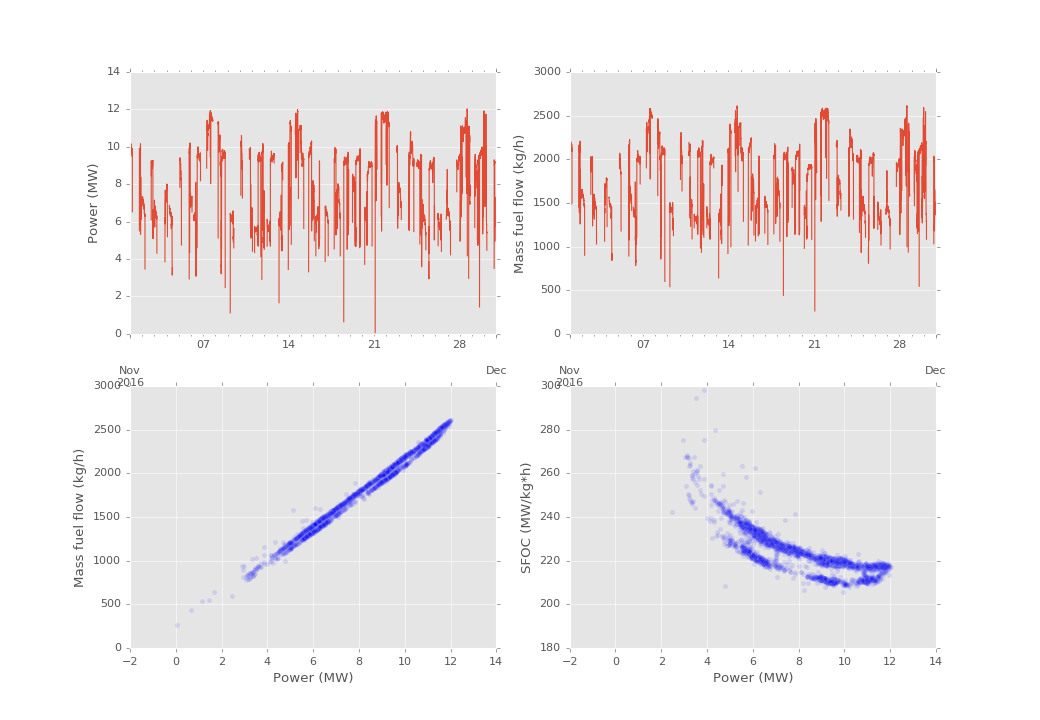

In [21]:
engine=0
sfc_model.plot_diagnostic(data,engine)

After checking the plots, we select the engines and an upper limit for the power range to model. We decide whether we want to model only one curve or two, using either 'False' or 'True' for the split parameter. We can also vary other parameters to adjust the model:
- The maximum power: determines the maximum power value for the SFC model. Must be higher than the maximum power value in the data.
- The outlier threshold: with this parameter we control the amount of datapoints to include in the linear fit. Increasing this parameter increases the amount of datapoints included in the fit. 150 is adequate in most cases. When there's a large gap between two fuel types we can increase it up to 500, for example.
- The scale length: this parameter controls the smoothness of the fit. 4 is adequate for most cases, but it can be decreased when less smoothness is needed to fit the data, or increased to increase smoothness of the fit. But beware of overfitting or underfitting.
- The fuel type: in the case 'split' is set into 'True' you can choose to fit only HFO, MDO, or both fuel types by setting this parameter to 'hfo', 'mdo', or 'None' respectively.

In [27]:
engines = ['1','2','3','4']
split = True
min_power = 0
max_power = 13
outlier_threshold = 150
scale_length = 4
fuel_type = 'None'
hfo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end, split=split, max_power=max_power, min_power=min_power,
                            out_threshold=outlier_threshold, scale_length=scale_length, fuel_type=fuel_type)
split_model = models.SplitFuelData(ship_id=ship, begin=begin, end=end)

mdo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end, split=split, max_power=max_power, min_power=min_power,
                            out_threshold=outlier_threshold, scale_length=scale_length, fuel_type=fuel_type)
sfc_model = models.SfcModel(hfo_model=hfo_model, mdo_model=mdo_model, split_model=split_model)
#sfc_model = tools.run_model(config, json_path=None)

In [28]:
data = split_model.run_split(data, engines, cluster_type=None)
data.head()

Using fuel density for clustering.
4408 4408
3801 3801
1829 1829
1217 1217


,power@generator.diesel.1,massFlowRate.fuel@engine.main.1,density.fuel.in@engine.main.1,temperature.fuel.in@engine.main.1,power@generator.diesel.2,massFlowRate.fuel@engine.main.2,density.fuel.in@engine.main.2,temperature.fuel.in@engine.main.2,power@generator.diesel.3,massFlowRate.fuel@engine.main.3,density.fuel.in@engine.main.3,temperature.fuel.in@engine.main.3,power@generator.diesel.4,massFlowRate.fuel@engine.main.4,density.fuel.in@engine.main.4,temperature.fuel.in@engine.main.4,fuel_type_1,fuel_type_2,fuel_type_3,fuel_type_4
time,,,,,,,,,,,,,,,,,,,,
2016-11-01 00:00:00+00:00,10.6010,2297.50,903.780,116.825,NaN,NaN,NaN,NaN,10.5565,2267.40,908.630,111.575,NaN,NaN,NaN,NaN,MDO,NaN,MDO,NaN
2016-11-01 00:05:00+00:00,10.5945,2305.55,904.060,116.480,NaN,NaN,NaN,NaN,10.6675,2280.55,908.830,111.370,NaN,NaN,NaN,NaN,MDO,NaN,MDO,NaN
2016-11-01 00:10:00+00:00,10.4500,2258.30,904.345,116.130,NaN,NaN,NaN,NaN,10.4770,2239.35,908.925,111.260,NaN,NaN,NaN,NaN,MDO,NaN,MDO,NaN
2016-11-01 00:15:00+00:00,10.5245,2267.55,904.475,115.965,NaN,NaN,NaN,NaN,10.4885,2247.10,908.830,111.250,NaN,NaN,NaN,NaN,MDO,NaN,MDO,NaN
2016-11-01 00:20:00+00:00,10.5315,2284.15,904.315,116.140,NaN,NaN,NaN,NaN,10.6130,2260.70,908.835,111.165,NaN,NaN,NaN,NaN,MDO,NaN,MDO,NaN


In [29]:
model_fit, xgp, data = sfc_model.fit(data, engines)
model_fit.head()

Modeling engine 1


/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:570: RuntimeWarning: divide by zero encountered in true_divide
  'model.ted.rig:sfc1@engine.main.' + engines[j]] = ff1 / xgp
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:585: RuntimeWarning: divide by zero encountered in true_divide
  j]] = ff2 / xgp


Modeling engine 2


/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:570: RuntimeWarning: divide by zero encountered in true_divide
  'model.ted.rig:sfc1@engine.main.' + engines[j]] = ff1 / xgp
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:585: RuntimeWarning: divide by zero encountered in true_divide
  j]] = ff2 / xgp


Modeling engine 3


/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:570: RuntimeWarning: divide by zero encountered in true_divide
  'model.ted.rig:sfc1@engine.main.' + engines[j]] = ff1 / xgp
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:585: RuntimeWarning: divide by zero encountered in true_divide
  j]] = ff2 / xgp


Modeling engine 4


/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:570: RuntimeWarning: divide by zero encountered in true_divide
  'model.ted.rig:sfc1@engine.main.' + engines[j]] = ff1 / xgp
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:585: RuntimeWarning: divide by zero encountered in true_divide
  j]] = ff2 / xgp


,model.ted.rig:sfc1@engine.main.1,model.ted.rig:sfc2@engine.main.1,model.ted.rig:sfc1@engine.main.2,model.ted.rig:sfc2@engine.main.2,model.ted.rig:sfc1@engine.main.3,model.ted.rig:sfc2@engine.main.3,model.ted.rig:sfc1@engine.main.4,model.ted.rig:sfc2@engine.main.4
0,inf,inf,inf,inf,inf,inf,inf,inf
1,4023.033687,3598.798112,7112.280562,4110.357901,5561.420913,6594.282045,6222.447152,3532.962725
2,2077.272025,1862.239145,3547.837299,2113.203119,2798.667367,3292.248923,3119.333385,1837.879276
3,1429.177656,1283.854276,2360.439830,1448.184268,1878.871072,2192.396584,2085.896017,1273.604039
4,1105.486481,995.003113,1767.357380,1116.192041,1419.844258,1643.141868,1569.915477,992.012037


In [ ]:
# engines = ['6']
# split = False
# min_power = 0
# max_power = 4
# outlier_threshold = 150
# scale_length = 4
# fuel_type = 'mdo'
# hfo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end, split=split, max_power=max_power, min_power=min_power,
#                             out_threshold=outlier_threshold, scale_length=scale_length, fuel_type=fuel_type)
# split_model = models.SplitFuelData(ship_id=ship, begin=begin, end=end)
# mdo_model = models.SfcCalc(ship_id=ship, begin=begin, end=end, split=split, max_power=max_power, min_power=min_power,
#                             out_threshold=outlier_threshold, scale_length=scale_length, fuel_type=fuel_type)
# sfc_model = models.SfcModel(hfo_model=hfo_model, mdo_model=mdo_model, split_model=split_model)
# #sfc_model = tools.run_model(config, json_path=None)
# model_fit, xgp, data = sfc_model.fit(data, engines)
# model_fit.head()

We can save here the model parameters to a file.

In [76]:
#sfc_model.save_model(model_fit, engines, file='model_trial')
#load_model = models.SfcCalc()
#model_fit = models.SfcModel(hfo_model=load_model, mdo_model=load_model).load_model(file='model_trial')

/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/model_helpers/helper_features.py:51: UserWarning: Ignoring attempt to set value for invalid key 'gp_input_grid'. Valid keys: ['aggregation', 'begin', 'end', 'fuelflow_max', 'fuelflow_min', 'location', 'max_power', 'min_power', 'obs', 'obs_noise', 'out_threshold', 'scale_length', 'sfoc_plc', 'ship_id', 'split', 'step_power', 't_grid', 'training_default_fill', 'training_points']
  'Valid keys: {}'.format(key, sorted(self._defaults)))
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/model_helpers/helper_features.py:51: UserWarning: Ignoring attempt to set value for invalid key 'gp_input_vals'. Valid keys: ['aggregation', 'begin', 'end', 'fuelflow_max', 'fuelflow_min', 'location', 'max_power', 'min_power', 'obs', 'obs_noise', 'out_threshold', 'scale_length', 'sfoc_plc', 'ship_id', 'split', 'step_power', 't_grid', 'training_default_fill', 'training_points']
  'Valid keys: {}'.format(key, sorted(self._defaults)))


Now let's validate the model by plotting the model with the data for a single engine (as an array index):

<IPython.core.display.Javascript object>


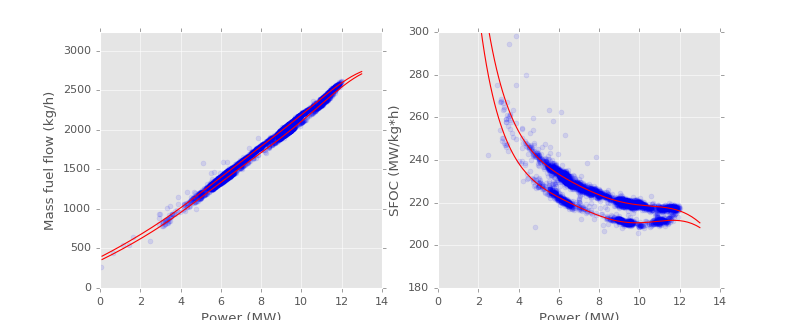

Root Mean Square Error 1 =  119.241027001
Root Mean Square Error 2 =  19.7008389606


In [30]:
i=0
engine = engines[i]
sfc_model.plot_model(data,i,engine, model_fit)

Here we calculate the predicted mass fuel flow and SFC curve and compare with another set of data. We can visualise the predictions and comparisons with the following plots: 
- Predicted SFC at 75% load vs. measured SFC,
- Predicted SFC vs. measured SFC,
- Predicted mass fuel flow vs. measured mass fuel flow.

1014-002
12:51: Reading data with begin=2017-10-01 and end=2017-10-30 from http://rest.eniram.io/hdf5rest/
Data time range 2017-10-01 00:00:00+00:00...2017-10-29 23:59:30+00:00
Loading data... engine 1
Using fuel density for clustering.
3461 3461
Fuel type split from clustering methods


/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:812: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_0['avg_model'] = avg_model_0
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:813: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_1['avg_model'] = avg_model_1
/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/sfc17/models.py:816: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

<IPython.core.display.Javascript object>


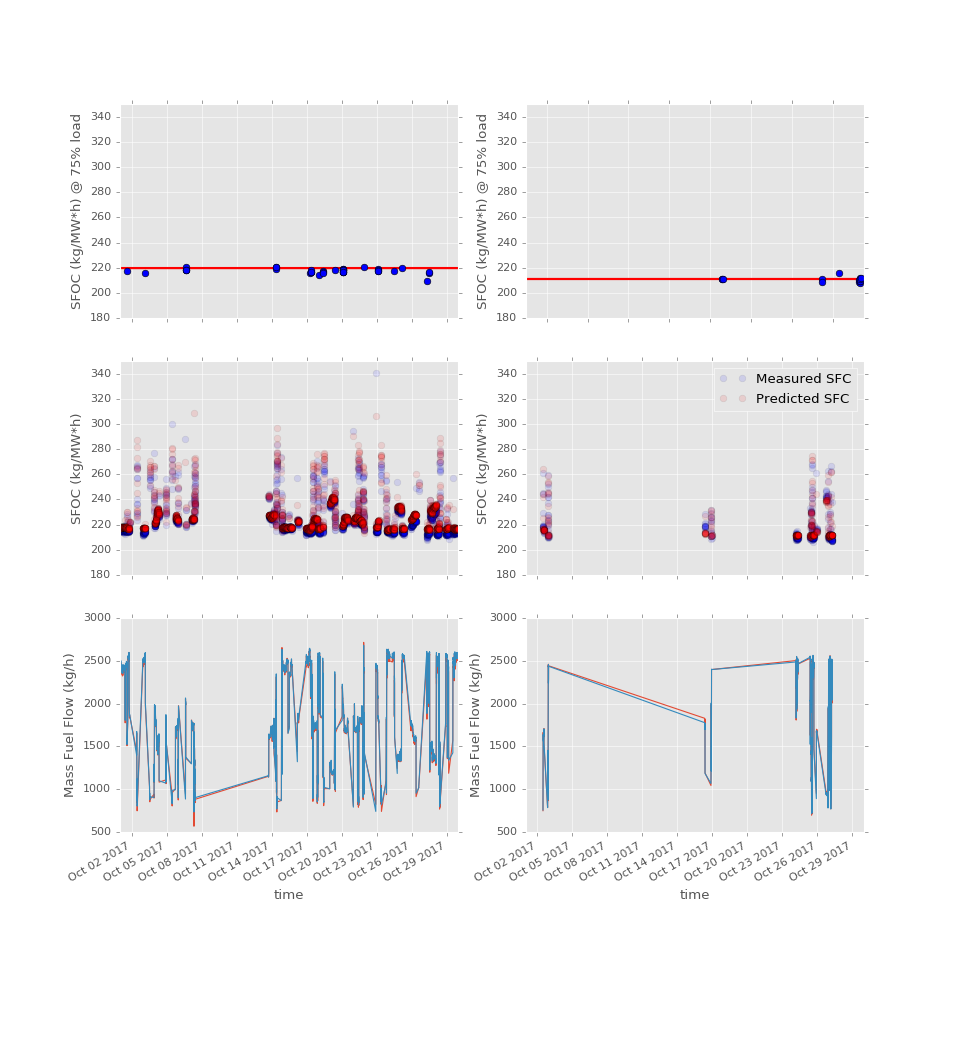

/home/devvm/src/venv/enipy2016-py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [31]:
begin_test = '2017-10-01'
end_test = '2017-10-30'
hfo_model = models.SfcCalc(ship_id=ship, begin=begin_test, end=end_test, split=split, max_power=max_power, min_power=min_power,
                            out_threshold=outlier_threshold, scale_length=scale_length)
split_model = models.SplitFuelData(ship_id=ship, begin=begin_test, end=end_test)
mdo_model = models.SfcCalc(ship_id=ship, begin=begin_test, end=end_test, split=split, max_power=max_power, min_power=min_power,
                            out_threshold=outlier_threshold, scale_length=scale_length)
sfc_model = models.SfcModel(hfo_model=hfo_model, mdo_model=mdo_model, split_model=split_model)
pred = sfc_model.predict(model_fit,i,engine, begin_test, end_test)

In [ ]:
# begin_test = '2016-08-01'
# end_test = '2016-09-01'
# i=2
# engine = engines[i]
# model = models.SFCModel(**config)
# pred = model.predict(model_fit,i,engine, begin_test, end_test)